In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import argparse
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
import logging
import os
import math
import copy
import matplotlib.pyplot as plt
import optuna
from datetime import datetime
import random
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
import copy

import scipy.stats


In [2]:
import sys
sys.path.append('..')

In [3]:
from src.data.data_loader import MIMICDataset,import_data
from src.utils import setup_logger
from src.training.training_nn import *
from src.models.models import ODERNN,GRU
from src.utils import seed_everything

In [4]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [5]:
# seed

DATA_PATH = "../data/analysis.csv"
df = import_data(DATA_PATH)
df.glc = glc_transform(df.glc)
df.glc_1 = glc_transform(df.glc_1)
df['t0'] = df.timer_hr
df['t1'] = df.timer_hr + df.dt
df['glc'] = df.groupby('icustay_id').glc.fillna(method='ffill')
df = df.loc[~df.glc.isnull()]

# df['input'] = df['input']/50
# df['input_hrs'] = df['input_hrs']/30

qt = QuantileTransformer(n_quantiles=10, random_state=0)
df['input'] = qt.fit_transform(df['input'].to_numpy().reshape(-1, 1))
qt = QuantileTransformer(n_quantiles=10, random_state=0)
df['input_hrs'] = qt.fit_transform(df['input_hrs'].to_numpy().reshape(-1, 1))

sample_ids = df.icustay_id.unique()[0:5000]

train_ids, test_ids = train_test_split(sample_ids,test_size=0.25)

train_ids, test_ids = train_test_split(df.icustay_id.unique(),test_size=0.25)

df_train = df.loc[df.icustay_id.isin(train_ids)]
df_valid = df.loc[df.icustay_id.isin(test_ids)]


excluding: 234981
excluding: 297801
excluding: 289280
excluding: 281374
excluding: 221828
excluding: 280186
excluding: 237411
excluding: 280745
excluding: 226061
excluding: 249123
excluding: 280799
excluding: 253567
excluding: 265402
excluding: 213468
excluding: 274648
excluding: 296828
excluding: 251353
excluding: 253448
excluding: 229929
excluding: 285794
excluding: 228667
excluding: 227099
excluding: 255499
excluding: 263747
excluding: 262078
excluding: 294580
excluding: 290772
excluding: 206288
excluding: 284250
excluding: 221647
excluding: 263642
excluding: 275903
excluding: 248988
excluding: 288820
excluding: 238796
excluding: 241858


In [6]:
FEATURE_VARS = ["injection","input_hrs","input","glc"]
TIME_VARS = ["t0","t1"]

class MIMICDataset(Dataset):
    """
    Args:
        patientunitstayids: 
        df:
        ...
    
    Example:
    """
    def __init__(self,df,verbose=True):
        self.X,self.y,self.msk,self.dt = self.load_data(df,verbose=verbose)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx],self.msk[idx],self.dt[idx]
    
    def load_data(self,df,verbose):
        X_list, y_list, msk_list, dt_list = [], [], [], []
        ids = df.icustay_id.unique()
        if verbose:
            print("reconfiguring data...")
        for id_ in ids:
            df_id = df.loc[df.icustay_id == id_,:]
            if (sum(df_id.msk) == df_id.shape[0]):
                print("excluding:",id_)
                continue
            X = df_id.loc[:,FEATURE_VARS]
            y = df_id.loc[:,"glc_1"]
            msk = df_id.loc[:,"msk"]
            dt = df_id.loc[:,TIME_VARS]
            X = np.array(X).astype(np.float32)
            y = np.array(y).astype(np.float32)
            msk = np.array(msk).astype(np.int32)
            dt = np.array(dt).astype(np.float32)
            X_list.append(X)
            y_list.append(y)
            msk_list.append(msk)
            dt_list.append(dt)
        return X_list,y_list,msk_list,dt_list

In [7]:
dl_train = DataLoader(MIMICDataset(df_train),batch_size=1)
dl_valid = DataLoader(MIMICDataset(df_valid),batch_size=1)
dataloaders = {'train':dl_train,'validation':dl_valid}

reconfiguring data...
excluding: 258717
reconfiguring data...
excluding: 241162


In [8]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import math

# Base ----------------------------------------------------------------------------

import torch.nn.functional as F

class Baseline(nn.Module):
    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        super(Baseline, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.p = p
        self.device = device
        
    def train_single_epoch(self,dataloader,optim):
        loss = 0.0
        for i, (x, y, msk, dt) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.view(-1,1).to(self.device)
            dt = dt.to(self.device)
            msk = msk.bool().to(self.device)
            optim.zero_grad()
            preds = self.forward(dt,x)
            loss_step = self.loss_fn(preds,y,~msk.squeeze(0))
            loss_step.backward()
            #torch.nn.utils.clip_grad_norm_(self.parameters(), 10.0)
            optim.step()
            loss += loss_step.item()
            if i % 1e3 == 0:
                print("BATCH_loss : {:05.3f}".format(loss_step.item()))
        loss /= (i + 1)
        print("EPOCH_loss : {:05.3f}".format(loss))
        
        return loss
        
    def evaluate(self,dataloader,p=0.0):
        rmse, loss = 0., 0.
        N = 0
        y_preds = []
        y_tests = []
        msks = []
        #dts = []
        with tqdm(total=len(dataloader)) as t:
            for i, (x, y, msk, dt) in enumerate(dataloader):
                N += sum((msk == 0).squeeze(0)).item()
                x = x.to(self.device)
                y = y.view(-1,1).to(self.device)
                dt = dt.to(self.device)
                # model prediction
                y_ = self.forward(dt,x)
                y_preds.append([yc.detach().cpu().numpy() for yc in y_]) 
                y_tests.append(y.cpu().numpy())
                msk = msk.bool().to(self.device)
                rmse += self.get_sse(y_,y,~msk.squeeze(0)).item()
                loss += self.loss_fn(y_,y,~msk.squeeze(0)).item()
                msks.append(msk.cpu().numpy())
                t.update()
        rmse /= N
        loss /= (i + 1)
        rmse = math.sqrt(rmse)
        print("_rmse : {:05.3f}".format(rmse))
        print("_loss : {:05.3f}".format(loss))
        return loss,rmse, y_preds, y_tests, msks

    def get_sse(self,y_,y,msk):
        """
        SSE: sum of squared errors
        """
        if type(y_) == tuple:
            y_ = y_[0]
        c = torch.log(torch.tensor(140.0))
        rmse = torch.sum((torch.exp(y_[msk] + c) - torch.exp(y[msk] + c))**2)
        return rmse

In [9]:
def euler(func,y0,x,t,h):
    if (t[1]-t[0]) == 0:
        return y0
    else :
        tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
        hs = torch.diff(tsteps)
        y = copy.deepcopy(y0)
        for h in hs:
            y += h*func(y,x)
        return y 

In [10]:
class ODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,input_dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, y, x):
        yx = torch.cat((y,x),1)
        return self.net(yx)
    
class ODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = ODEFunc(input_dim).to(device)
        self.sigma = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Softplus()
        )
        
    def forward(self, dt, x):
        
        # encode - 'identity' encoder
        x = x.squeeze(0)
        dt = dt.squeeze(0)
        T = x.size(0)
        
        # ODE
        mu_out = torch.zeros(T,1,device = self.device)
        for i in range(0,T):
            y0 = x[i][3].unsqueeze(0).unsqueeze(0)
            x_i = x[i][:3].unsqueeze(0)
            mu_out[i] = euler(self.func,y0,x_i,dt[i],h=1.0)
            
        # decode 
        sigma_input = torch.cat((x.unsqueeze(0),mu_out.unsqueeze(0)),2).to(self.device)
        sigma_out = self.sigma(sigma_input)[0,:,:]
        
        return (mu_out,sigma_out)
    
    def loss_fn(self,mu_s_,y,msk):
        y_, s_ = mu_s_
        distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk])
        return -torch.mean(likelihood)


In [11]:
model = ODE(4, 1, 0.5, 1, "cuda").to("cuda")

In [39]:
t = next(iter(dl_train))[3].squeeze(0).to("cuda")
x = next(iter(dl_train))[0].squeeze(0).to("cuda")
y = next(iter(dl_train))[1].squeeze(0)
msk = next(iter(dl_train))[2].squeeze(0)
y_ = model(t,x)
print(len(y_))
model(t[:1].unsqueeze(0),x[:1].unsqueeze(0))
print(y_[1].shape)
# model(t[0],x[0]) # doesn't work but that's okay

2
torch.Size([98, 1])


In [13]:
model(t[:3],x[:3])

(tensor([[0.6769],
         [0.1087],
         [0.4191]], device='cuda:0', grad_fn=<CopySlices>),
 tensor([[0.7933],
         [0.7892],
         [0.7944]], device='cuda:0', grad_fn=<SliceBackward>))

In [14]:
model_optim = optim.RMSprop(model.parameters(), lr=1e-3)

In [15]:
model.train_single_epoch(dl_train,model_optim)
model.train_single_epoch(dl_train,model_optim)
model.train_single_epoch(dl_train,model_optim)
model.train_single_epoch(dl_train,model_optim)
model.train_single_epoch(dl_train,model_optim)

BATCH_loss : 0.760
BATCH_loss : 0.161
BATCH_loss : 0.019
BATCH_loss : -0.194
BATCH_loss : -0.265
BATCH_loss : -0.598
BATCH_loss : 0.585
BATCH_loss : -0.387
BATCH_loss : -0.053
BATCH_loss : -0.472
EPOCH_loss : 0.002


0.0017761398511894357

In [51]:
loss,rmse, y_preds, y_tests, msks = model.evaluate(dl_valid)

100%|██████████| 3011/3011 [02:05<00:00, 24.08it/s]

_rmse : 39.236
_loss : -0.008


In [17]:
rmse

39.23648686540101

In [18]:
df_valid["glc_1_locf"] = df_valid.glc
df_valid.loc[df_valid.glc_1_locf == 0,'glc_1_locf'] = np.NaN
df_valid["glc_1_locf"] = df_valid.groupby('icustay_id')["glc_1_locf"].ffill()
res_rmse_locf = math.sqrt(np.mean((ginv(df_valid.glc_1_locf[df_valid.msk==0]) - ginv(df_valid.glc_1[df_valid.msk==0]))**2))
print("RMSE (locf): {:05.4f}".format(res_rmse_locf))

RMSE (locf): 41.8159


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [19]:
rmse / res_rmse_locf

0.9383141250776871

In [52]:
mu_preds = [y[0] for y in y_preds]
s_preds = [y[1] for y in y_preds]

In [53]:
mu_preds = np.concatenate(mu_preds)
y_tests = np.concatenate(y_tests)

In [54]:
s_preds = np.concatenate(s_preds)

In [55]:
msks = np.concatenate([msk[0] for msk in msks])

In [60]:
len(y_tests)

141514

In [78]:
prob_test = scipy.stats.norm(mu_preds[~msks].reshape(-1,1), s_preds[~msks].reshape(-1,1)).cdf(y_tests[~msks])

(array([ 5645.,  7884., 10974., 14172., 18599., 15847., 10582.,  7840.,
         5780.,  4467.]),
 array([5.57176458e-19, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

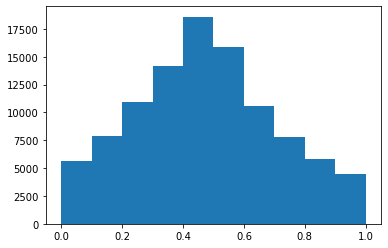

In [79]:
plt.hist(prob_test)

In [80]:
np.var(prob_test)

0.05396115557151737

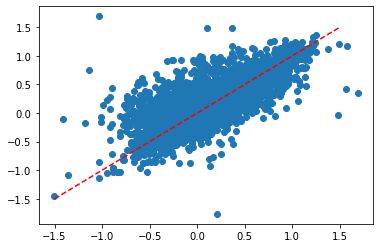

In [81]:
plt.scatter(mu_preds[msks],y_tests[msks])
xs = np.linspace(-1.5,1.5)
plt.plot(xs,xs,'--r')

In [82]:
mu_preds

array([[-0.15006368],
       [-0.05333729],
       [-0.19815966],
       ...,
       [-0.17297353],
       [-0.37285155],
       [-0.29027912]], dtype=float32)

In [83]:
t = next(iter(dl_train))[3].squeeze(0).to("cuda")
x = next(iter(dl_train))[0].squeeze(0).to("cuda")
y = next(iter(dl_train))[1].squeeze(0)
msk = next(iter(dl_train))[2].squeeze(0)
y_ = model(t,x)

In [84]:
# FEATURE_VARS = ["injection","input_hrs","input","glc"]

In [41]:
xx = torch.tensor([[0.0000,  0.0000, 0.000, 0.2412],
        [ 0.0000,  0.0000,  0.0000, 0.2412]], device='cuda:0')
print(ginv(xx[:,3].cpu().numpy()))
tt = torch.tensor([[0.0081, 3.0081],
        [3.0081, 3.4081]], device='cuda:0')
ys = model(tt,xx)
ginv(ys[0].detach().cpu().numpy())

[178.18855 178.18855]


array([[168.32649],
       [176.66199]], dtype=float32)

In [ ]:
ys = model(tt,xx)

In [ ]:
ginv(ys[0].detach().cpu().numpy())

In [92]:
sum((df_train.injection > 0) & (df_train.input > 0))

61177

(array([5.3834e+04, 5.4721e+04, 2.0918e+04, 1.3612e+04, 5.3930e+03,
        1.6530e+03, 5.6000e+02, 2.0500e+02, 1.5200e+02, 9.7000e+01,
        8.0000e+01, 5.1000e+01, 4.3000e+01, 2.4000e+01, 2.9000e+01,
        2.3000e+01, 1.5000e+01, 1.8000e+01, 1.4000e+01, 1.8000e+01]),
 array([0.15608256, 0.19776084, 0.23943913, 0.2811174 , 0.3227957 ,
        0.36447397, 0.40615225, 0.44783053, 0.4895088 , 0.5311871 ,
        0.57286537, 0.6145437 , 0.656222  , 0.69790024, 0.73957855,
        0.7812568 , 0.8229351 , 0.86461335, 0.90629166, 0.9479699 ,
        0.9896482 ], dtype=float32),
 <BarContainer object of 20 artists>)

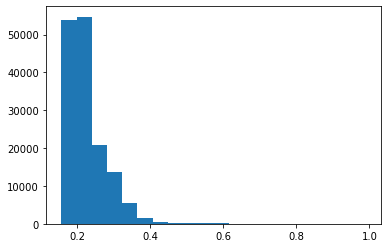

In [44]:
plt.hist(s_preds[s_preds<1.0],bins=20)